In [16]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


from datetime import datetime, timedelta


import sys
import os


sys.path.append(os.path.abspath('../..'))
from utils.db import get_db
from utils import find_missing_dates
from utils.fill_dates import fill_missing_dates
from utils.holidays import holidays

In [2]:
engine = get_db()

In [3]:
yesterday = datetime.now() - timedelta(days=1)
print(f"Yesterday: {yesterday.strftime('%m-%d-%Y')}") 
end_date = yesterday

Yesterday: 06-15-2025


In [4]:
query = f"""
select sale_date, sum(total_sales) as sales
    from sales
    where store_number='440'
    and sale_type in ('Sale')
    and item_ring_type in ('ITEM', 'SUBD')
    and sale_date between '1/1/2024' and '{end_date}'
group by sale_date
order by sale_date

"""

In [6]:
df = pd.read_sql(query, engine)

2025-06-16 19:33:31,642 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-16 19:33:31,643 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-06-16 19:33:31,643 INFO sqlalchemy.engine.Engine [cached since 11.41s ago] {'table_name': "\nselect sale_date, sum(total_sales) as sales\n    from sales\n    where store_number='440'\n    and sale_type in ('Sale')\n    and item_ring_type in ('ITEM', 'SUBD')\n    and sale_date between '1/1/2024' and '2025-06-15 19:33:02.432918'\ngroup by sale_date\norder by sale_date\n\n", 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v',

In [8]:

df['sale_date'] = pd.to_datetime(df['sale_date'])
df.sort_values('sale_date', inplace=True)
df.set_index('sale_date', inplace=True)

In [9]:
# --- Feature Engineering ---
df['trend'] = df['sales'].rolling(window=14, center=True, min_periods=1).mean()
df['lag_1'] = df['sales'].shift(1)
df['lag_7'] = df['sales'].shift(7)
df['lag_mean_1_7'] = df[['lag_1', 'lag_7']].mean(axis=1)
df['detrended'] = df['sales'] - df['trend']
df['weekday'] = df.index.dayofweek
seasonality = df.groupby('weekday')['detrended'].mean()
df['seasonality'] = df['weekday'].map(seasonality)

In [10]:
# Merge holiday effects
df = df.merge(holidays, how='left', left_index=True, right_index=True)
df['is_holiday'] = df['holiday'].notna().astype(int)
df['residual'] = df['detrended'] - df['seasonality']
per_holiday_effect = df[df['holiday'].notna()].groupby('holiday')['residual'].mean()
df['holiday_effect'] = df['holiday'].map(per_holiday_effect).fillna(0)

In [11]:
# --- Final Feature Set ---
df.dropna(subset=['trend', 'lag_1', 'lag_7', 'lag_mean_1_7'], inplace=True)
features = ['trend', 'lag_1', 'lag_7', 'lag_mean_1_7', 'seasonality', 'is_holiday', 'weekday']
X = df[features]
y = df['sales']

In [13]:
# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [14]:
# --- Train Random Forest Model ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [17]:
# --- Predict and Evaluate ---
df.loc[X_test.index, 'forecast_rf'] = model.predict(X_test)
mae_rf = mean_absolute_error(y_test, df.loc[X_test.index, 'forecast_rf'])
mape_rf = mean_absolute_percentage_error(y_test, df.loc[X_test.index, 'forecast_rf'])

In [28]:
print(f'mae: {mae_rf}, mape: {mape_rf}')

mae: 2861.5699195896245, mape: 0.09249914267692315


In [24]:
# --- Forecast Forward ---
future_days = 30
future_dates = pd.date_range(start=df.index.max() + pd.Timedelta(days=1), periods=future_days)
future_df = pd.DataFrame(index=future_dates)
future_df['dayofweek'] = future_df.index.dayofweek
future_df['weekday'] = future_df.index.dayofweek
recent = df.iloc[-7:].copy()
future_df['lag_1'] = df['sales'].iloc[-1]
future_df['lag_7'] = recent['sales'].iloc[0]
future_df['lag_mean_1_7'] = (future_df['lag_1'] + future_df['lag_7']) / 2
recent_trend = df['trend'].dropna().tail(30)
x = np.arange(len(recent_trend))
slope, _ = np.polyfit(x, recent_trend.values, 1)
last_trend = recent_trend.values[-1]
future_df['trend'] = slope * np.arange(1, future_days + 1) + last_trend
future_df['seasonality'] = future_df['dayofweek'].map(seasonality)
future_df = future_df.merge(holidays, how='left', left_index=True, right_index=True)
future_df['is_holiday'] = future_df['holiday'].notna().astype(int)

X_future = future_df[features]
future_df['forecast_rf'] = model.predict(X_future)

In [27]:
#future_df

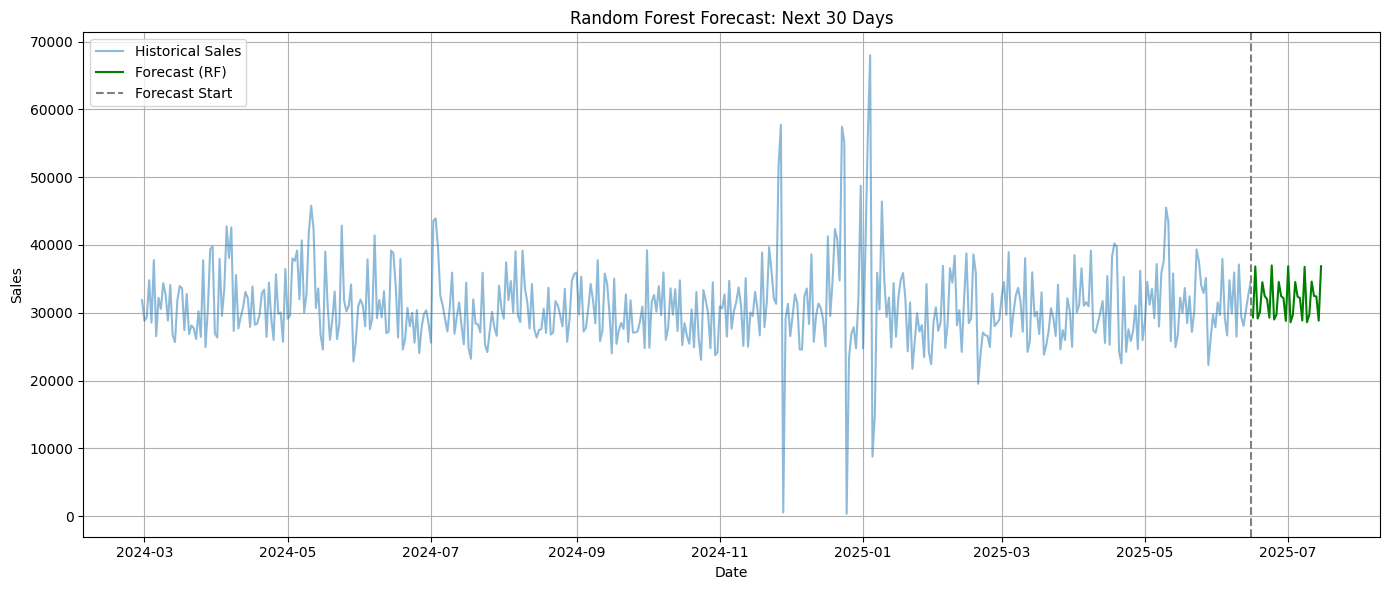

In [25]:
# --- Plot Results ---
combined_forecast = pd.concat([df[['sales']], future_df[['forecast_rf']]], axis=0)
plt.figure(figsize=(14, 6))
plt.plot(combined_forecast.index, combined_forecast['sales'], label='Historical Sales', alpha=0.5)
plt.plot(combined_forecast.index, combined_forecast['forecast_rf'], label='Forecast (RF)', color='green')
plt.axvline(x=df.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title("Random Forest Forecast: Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()